In [2]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import plots
import functions
import glob
import os
import pandas as pd
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
import functions
import scipy.io
import statsmodels.api as sm
from scipy.stats import norm
from scipy import integrate

## Reading nadir data

In [4]:
nadir = pd.read_csv('NadirData.csv')
time_nadir = pd.to_datetime(nadir['time_nadir'])

In [5]:
time = nadir['time_nadir'].values
start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")

# nadir = nadir.where((time_nadir >= start) & (time_nadir <= end)).dropna()
nadir = nadir.loc[(time_nadir >= start) & (time_nadir <= end)]
time_nadir = pd.to_datetime(nadir['time_nadir'])

In [6]:
len(nadir)

2571

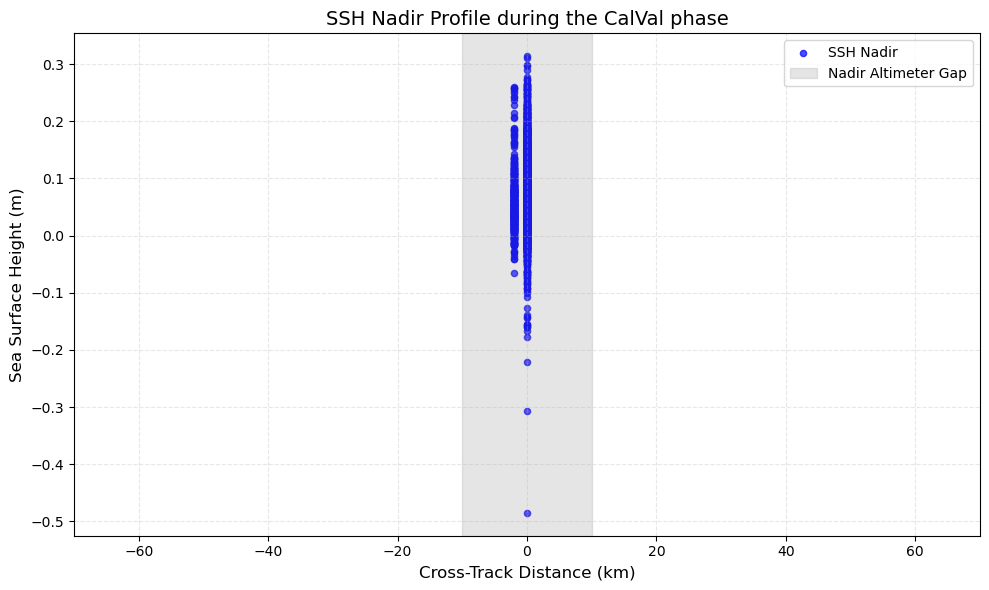

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(nadir['cross_track_distance'], nadir.sla_nadir, 
                    color='blue', alpha=0.7, s=20, label='SSH Nadir')

ax.axvspan(-10, 10, alpha=0.2, color='gray', label='Nadir Altimeter Gap')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlabel('Cross-Track Distance (km)', fontsize=12)
ax.set_ylabel('Sea Surface Height (m)', fontsize=12)
ax.set_title('SSH Nadir Profile during the CalVal phase', fontsize=14)
ax.legend()
ax.set_xlim(-70, 70)  
plt.tight_layout()
# plt.savefig('mean_SSH_Nadir.png', dpi=300)

## Selecting the cross-track line above the SWOT2 mooring

In [9]:
time_nadir.values

array(['2023-04-07T12:59:10.946603264', '2023-04-07T12:59:11.878242432',
       '2023-04-07T12:59:13.120405504', ...,
       '2023-07-09T22:19:03.232895104', '2023-07-09T22:19:04.164371072',
       '2023-07-09T22:19:05.406262912'], dtype='datetime64[ns]')

In [10]:
#Selecting the entire row that has the latitude closest to target latitude for each day.

nadir['date'] = time_nadir.dt.date
target_lat = 50.16467
target_lon = -53.26417

closest_points = []

for date, group in nadir.groupby('date'):
    distances = []
    for idx, row in group.iterrows():
        lat =row['latitude_nadir']
        lon = row['longitude_nadir']
        distance = functions.haversine_distance(target_lat, target_lon, lat, lon)
        distances.append(distance)
    # lat_diff = np.abs(group['latitude_nadir'] - target_latitude)
    distances_series = pd.Series(distances, index=group.index)   
    closest_idx = distances_series.idxmin()
    
    closest_points.append(nadir.loc[closest_idx])

In [11]:
nadir_line = pd.DataFrame(closest_points)
time_nadir_line = pd.to_datetime(nadir_line['time_nadir'])

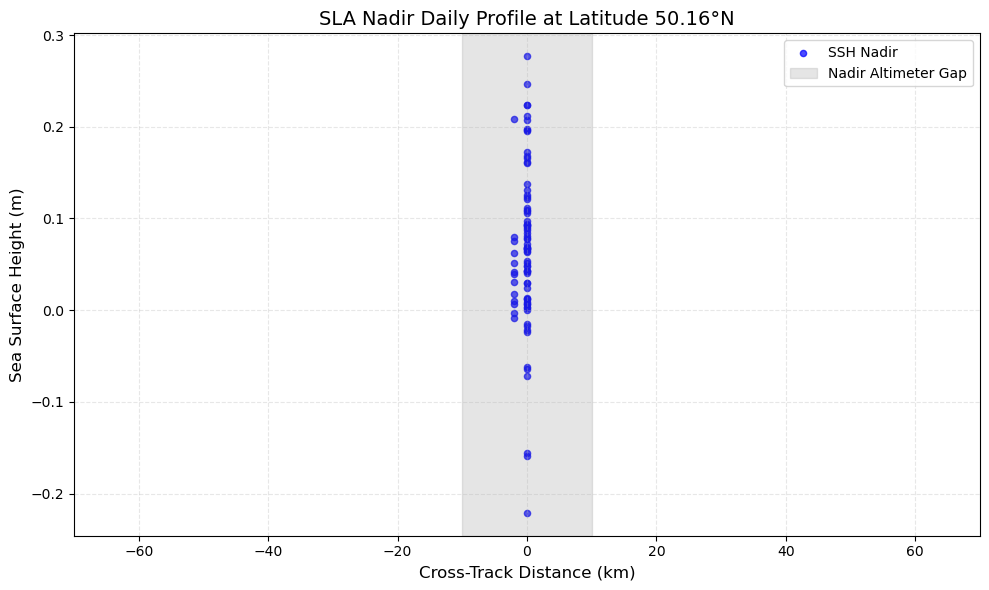

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(nadir_line['cross_track_distance'], nadir_line.sla_nadir, 
                    color='blue', alpha=0.7, s=20, label='SSH Nadir')
ax.axvspan(-10, 10, alpha=0.2, color='gray', label='Nadir Altimeter Gap')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlabel('Cross-Track Distance (km)', fontsize=12)
ax.set_ylabel('Sea Surface Height (m)', fontsize=12)
ax.set_title(f'SLA Nadir Daily Profile at Latitude {target_lat:.2f}°N', fontsize=14)
ax.legend()
ax.set_xlim(-70, 70) 
plt.tight_layout()
# plt.savefig('mean_SSH_Nadir_SWOT2.png', dpi=300)

In [13]:
data_KaRin = xr.open_dataset('KaRin_data_line.nc')
data_KaRin

<xarray.Dataset>
Dimensions:               (num_pixels: 69, num_lines: 99)
Coordinates:
    latitude              (num_pixels, num_lines) float64 ...
    longitude             (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_pixels, num_lines
Data variables:
    ssha_filtered         (num_lines, num_pixels) float64 ...
    mdt                   (num_lines, num_pixels) float64 ...
    ugos_line             (num_lines, num_pixels) float64 ...
    vgos_line             (num_lines, num_pixels) float64 ...
    time                  (num_lines) datetime64[ns] ...
    cross_track_distance  (num_pixels) float64 ...

In [14]:
time = data_KaRin['time'].values
start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")

data_KaRin = data_KaRin.where((data_KaRin.time >= start) & (data_KaRin.time <= end), drop=True)
data_KaRin_bis = data_KaRin.where((data_KaRin.cross_track_distance < -10) | (data_KaRin.cross_track_distance > 10), drop=True)

In [15]:
print(data_KaRin.cross_track_distance.values[:,0])
print(data_KaRin_bis.cross_track_distance.values[:,0])

[-68. -66. -64. -62. -60. -58. -56. -54. -52. -50. -48. -46. -44. -42.
 -40. -38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14.
 -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.  12.  14.
  16.  18.  20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.
  44.  46.  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.]
[-68. -66. -64. -62. -60. -58. -56. -54. -52. -50. -48. -46. -44. -42.
 -40. -38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14.
 -12.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.  34.  36.
  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.  62.  64.
  66.  68.]


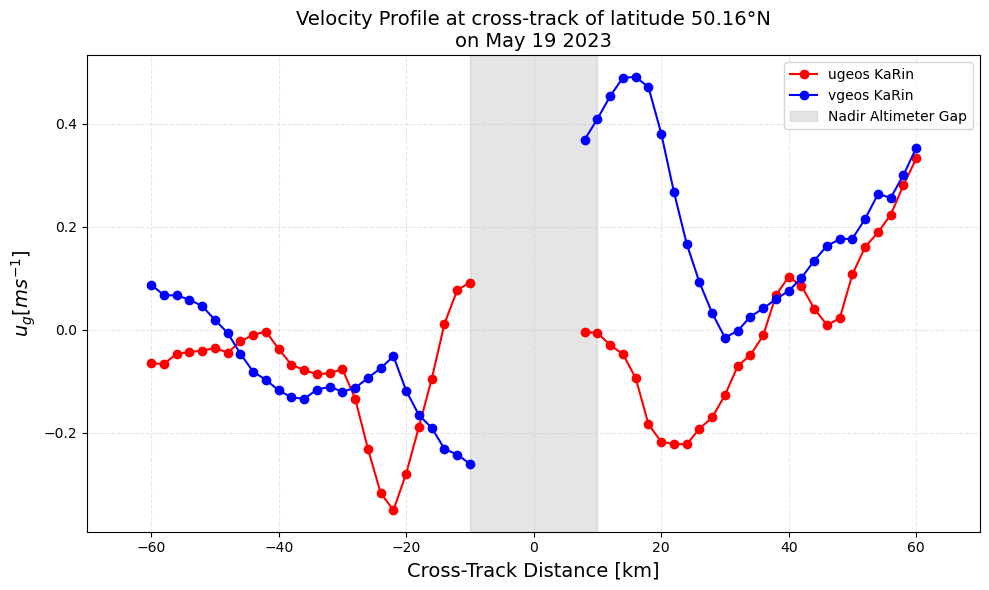

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(data_KaRin.cross_track_distance.T[42,:],data_KaRin.vgos_line[42,:], 'ro-',label='ugeos KaRin')
plt.plot(data_KaRin.cross_track_distance.T[42,:],data_KaRin.ugos_line[42,:], 'bo-',label='vgeos KaRin')
ax.axvspan(-10, 10, alpha=0.2, color='gray', label='Nadir Altimeter Gap')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlabel('Cross-Track Distance [km]', fontsize=14)
ax.set_ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)
ax.set_title(f'Velocity Profile at cross-track of latitude {target_lat:.2f}°N\non May 19 2023', fontsize=14)
ax.legend()
ax.set_xlim(-70, 70)  
plt.tight_layout()
# plt.savefig('Figures/ugeos_interpolated_may19', dpi=300)

In [17]:
interp_x = np.linspace(-60, 60, 100)
times = []
sla_data = []
mdt_data = []
lon = []
lat = []

data_KaRin['date_hour'] = data_KaRin['time'].dt.strftime('%Y-%m-%d %H')
nadir_line['date_hour'] = time_nadir_line.dt.strftime('%Y-%m-%d %H')
nadir_hours = nadir_line['date_hour'].unique()

for date_hour in nadir_line['date_hour'].unique():

    karin_day = data_KaRin.where(data_KaRin['date_hour'] == date_hour, drop=True)
    nadir_day = nadir_line[nadir_line['date_hour'] == date_hour]
  
    if karin_day.time.size == 0 or nadir_day.empty:
        continue

    karin_x = np.array(karin_day.cross_track_distance)
    karin_sla = np.array(karin_day.ssha_filtered)
    karin_mdt = np.array(karin_day.mdt)
    
    nadir_x = np.array(nadir_day['cross_track_distance'])
    nadir_sla = np.array(nadir_day['sla_nadir'])
    lon_nadir = np.array(nadir_day['longitude_nadir'])
    lat_nadir = np.array(nadir_day['latitude_nadir'])

    combined_x = np.append(karin_x, nadir_x)
    combined_sla = np.append(karin_sla, nadir_sla)
    
    mask = ~np.isnan(combined_sla)
    x_valid = combined_x[mask]
    sla_valid = combined_sla[mask]

    if len(x_valid) < 2:
        continue  # skip if not enough data to interpolate
    
    sla_interp_func = interp1d(x_valid, sla_valid, kind='linear', fill_value="extrapolate")
    sla_interp = sla_interp_func(interp_x)

    mdt_interp_func = interp1d(karin_x[:, 0], karin_mdt[0], kind='linear', fill_value="extrapolate")
    mdt_interp = mdt_interp_func(interp_x)

    karin_lon = np.array(karin_day.longitude)
    karin_lat = np.array(karin_day.latitude)
    
    lon_interp_func = interp1d(karin_x[:, 0], karin_lon[0], kind='linear', fill_value="extrapolate")
    lat_interp_func = interp1d(karin_x[:, 0], karin_lat[:,0], kind='linear', fill_value="extrapolate")
    
    lon_interp = lon_interp_func(interp_x)
    lat_interp = lat_interp_func(interp_x)
    
    lon.append(lon_interp)
    lat.append(lat_interp)
    
    sla_data.append(sla_interp)
    mdt_data.append(mdt_interp)
    times.append(pd.to_datetime(date_hour))

In [18]:
sla_da = xr.DataArray(
    data=np.array(sla_data),
    dims=["time", "cross_track_distance"],
    coords={
        "longitude": (["time", "cross_track_distance"], lon),
        "latitude": (["time", "cross_track_distance"], lat)
    },
    name="sla_interp"
)

mdt_da = xr.DataArray(
    data=np.array(mdt_data),
    dims=["time", "cross_track_distance"],
    coords={
        "longitude": (["time", "cross_track_distance"], lon),
        "latitude": (["time", "cross_track_distance"], lat)
    },
    name="mdt_interp"
)

swot2_data = xr.Dataset({"sla": sla_da, "mdt": mdt_da})

In [19]:
swot2_data

<xarray.Dataset>
Dimensions:    (time: 83, cross_track_distance: 100)
Coordinates:
    longitude  (time, cross_track_distance) float64 307.5 307.5 ... 305.9 305.9
    latitude   (time, cross_track_distance) float64 50.3 50.3 ... 49.99 49.99
Dimensions without coordinates: time, cross_track_distance
Data variables:
    sla        (time, cross_track_distance) float64 0.1509 0.1534 ... 0.0585
    mdt        (time, cross_track_distance) float64 -0.2533 -0.2527 ... -0.1284

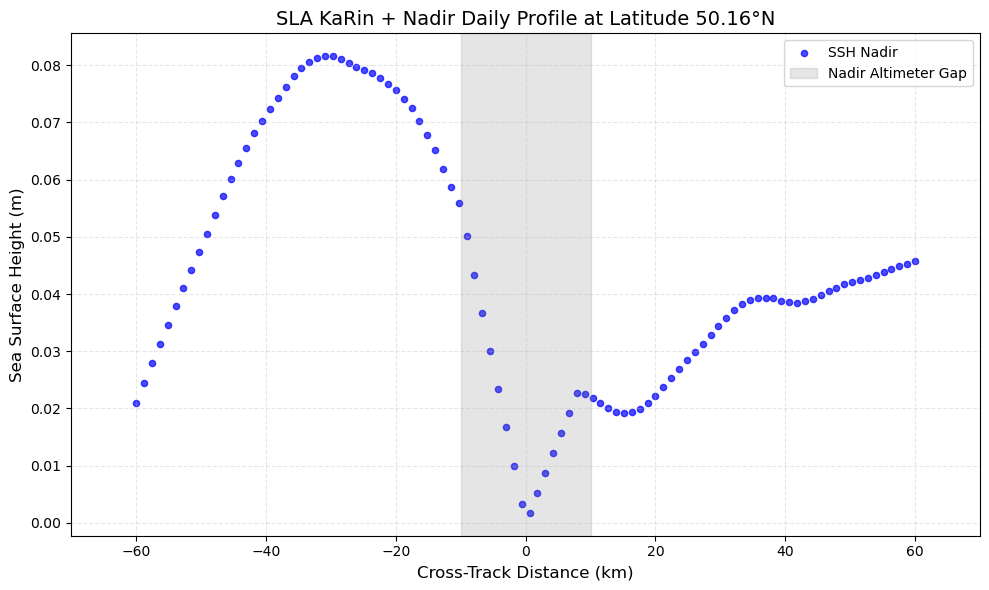

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(interp_x, swot2_data.sla[50,:], 
                    color='blue', alpha=0.7, s=20, label='SSH Nadir')

ax.axvspan(-10, 10, alpha=0.2, color='gray', label='Nadir Altimeter Gap')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlabel('Cross-Track Distance (km)', fontsize=12)
ax.set_ylabel('Sea Surface Height (m)', fontsize=12)
ax.set_title(f'SLA KaRin + Nadir Daily Profile at Latitude {target_lat:.2f}°N', fontsize=14)
ax.legend()
ax.set_xlim(-70, 70)  
plt.tight_layout()

In [21]:
# swot2_data.sla[0,:]

In [22]:
u_interp = []
v_interp = []
for i in range(len(data_KaRin_bis.time)):

    x_data = data_KaRin_bis.cross_track_distance.T[i]
    u_data = data_KaRin_bis.ugos_line[i]
    v_data = data_KaRin_bis.vgos_line[i]
    
    interp_func = interp1d(x_data, u_data, kind='linear', fill_value="extrapolate")   
    interp_func_v = interp1d(x_data, v_data, kind='linear', fill_value="extrapolate")
    new_x = np.linspace(-60, 60, data_KaRin.dims['num_pixels'])
    u_interp.append(interp_func(new_x))  
    v_interp.append(interp_func_v(new_x))


dims = data_KaRin.ssha_filtered.dims
data_KaRin = data_KaRin.assign(ugos_interp = (dims, u_interp), vgos_interp = (dims,v_interp))

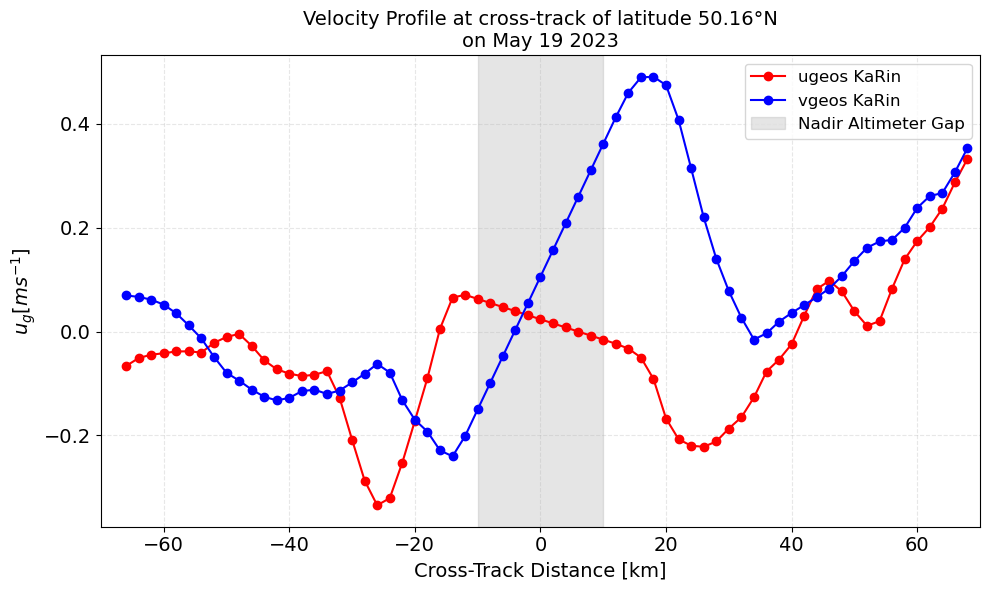

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(data_KaRin.cross_track_distance.T[42,:],data_KaRin.vgos_interp[42,:], 'ro-',label='ugeos KaRin')
plt.plot(data_KaRin.cross_track_distance.T[42,:],data_KaRin.ugos_interp[42,:], 'bo-',label='vgeos KaRin')

ax.axvspan(-10, 10, alpha=0.2, color='gray', label='Nadir Altimeter Gap')
# plt.axvline(data_KaRin.cross_track_distance.T[42,38], color='k', linestyle='--', linewidth=1, alpha=0.7)
# plt.axvline(data_KaRin.cross_track_distance.T[42,39], color='k', linestyle='--', linewidth=1, alpha=0.7)
# plt.axvline(data_KaRin.cross_track_distance.T[42,29], color='k', linestyle='--', linewidth=1, alpha=0.7)

ax.grid(alpha=0.3, linestyle='--')
ax.set_xlabel('Cross-Track Distance [km]', fontsize=14)
ax.set_ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)
ax.set_title(f'Velocity Profile at cross-track of latitude {target_lat:.2f}°N\non May 19 2023', fontsize=14)
ax.legend(fontsize=12)

ax.set_xlim(-70, 70)  # Adjust based on your data range
plt.tick_params(axis='both', labelsize=14, colors='k')
plt.tight_layout()
# plt.savefig('Figures/ugeos_interpolated_may19', dpi=300)

In [24]:
lon_mooring2 = -53.264167
lat_mooring2 = 50.164667
lon = (( data_KaRin.longitude + 180 )% 360) - 180
radius = 2 #km
dist = functions.haversine_distance(data_KaRin.latitude, lon, lat_mooring2, lon_mooring2)
mask = dist < radius
ugeos_mooring = data_KaRin.ugos_interp.where(mask, drop=True)
vgeos_mooring = data_KaRin.vgos_interp.where(mask, drop=True)

In [25]:
dm = xr.open_dataset('Mooring_data_CalVal/SWOT2_01.nc')
time_m = dm['TIME'].values
start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")
dm = dm.where((dm.DEPTH <= -10), drop=True)
dm_FS = dm.where((dm.TIME >= start) & (dm.TIME <= end), drop=True)
velocity_east = dm_FS['velocity_east'].values
velocity_north = dm_FS['velocity_north'].values
depth = dm_FS['DEPTH'].values
depth_mask = (depth >= -65) & (depth <= -30)
u_layer = dm_FS.velocity_east.sel(DEPTH=depth_mask)
v_layer = dm_FS.velocity_north.sel(DEPTH=depth_mask)

In [26]:
dm_u_layer = pd.DataFrame({'Time':dm_FS.TIME, 'Value': np.nanmean(u_layer, axis=1)})
dm_u_layer = dm_u_layer.set_index('Time')
dm_u_layer = dm_u_layer.resample('1h').mean()
filtered_u_layer = functions.filter_velocity(dm_u_layer['Value'])

dm_v_layer = pd.DataFrame({'Time':dm_FS.TIME, 'Value': np.nanmean(v_layer, axis=1)})
dm_v_layer = dm_v_layer.set_index('Time')
dm_v_layer = dm_v_layer.resample('1h').mean()
filtered_v_layer = functions.filter_velocity(dm_v_layer['Value'])

In [27]:
ugeos_mooring.shape

(92, 2)

In [28]:
ugeos_mean = np.nanmean(ugeos_mooring, axis=1)
vgeos_mean = np.nanmean(vgeos_mooring, axis=1)

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_35962/1524376827.py:1: RuntimeWarning: Mean of empty slice
  ugeos_mean = np.nanmean(ugeos_mooring, axis=1)
/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_35962/1524376827.py:2: RuntimeWarning: Mean of empty slice
  vgeos_mean = np.nanmean(vgeos_mooring, axis=1)


In [72]:
df_swot_u = pd.DataFrame({
    'time': pd.to_datetime(data_KaRin.time.values),
    'u_total': ugeos_mean 
})

daily = df_swot_u.groupby(df_swot_u['time'].dt.date)
daily_mean = daily['u_total'].mean()
daily_time = daily['time'].apply(lambda x: x.iloc[0])  

df_swot_u = pd.DataFrame({
    'time': daily_time.values,
    'u_total_mean': daily_mean.values
}).set_index('time')



df_swot_v = pd.DataFrame({
    'time': pd.to_datetime(data_KaRin.time.values,),
    'v_total': vgeos_mean  
})

daily_v = df_swot_v.groupby(df_swot_v['time'].dt.date)
daily_mean_v = daily_v['v_total'].mean()

df_swot_v = pd.DataFrame({
    'time': daily_time.values,
    'v_total_mean': daily_mean_v.values
}).set_index('time')

In [30]:
df_interp_swot_u = df_swot_u.interpolate(method='linear')
filtered_swot_u = functions.butter_filter_velocity(df_swot_u.index, df_interp_swot_u['u_total_mean'])

df_interp_swot_v = df_swot_v.interpolate(method='linear')
filtered_swot_v = functions.butter_filter_velocity(df_swot_v.index, df_interp_swot_v['v_total_mean'])
# plt.figure(figsize=(12, 6))
# plt.plot(df_interp_swot_u['u_total_mean'], label='original')
# plt.plot(df_swot_u.index, filtered_swot_u, 'r',linestyle='--',label='48h filter')
# plt.xlabel('Time', fontsize=14)
# plt.ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)
# plt.title('Time series of zonal geostrophic velocities during the fast sampling period', fontsize=16)
# plt.grid(True)
# plt.legend();

In [31]:
def find_nearest_index(time, target_time):
    return np.argmin(np.abs(time - target_time))

satellite_time =  np.array(df_swot_u.index) 
time_indices = [find_nearest_index(dm_FS.TIME.values, sat_time) for sat_time in satellite_time]

In [32]:
mask_nan = ~np.isnan(filtered_swot_u) & ~np.isnan(filtered_u_layer[time_indices])
u_mooring = filtered_u_layer[time_indices][mask_nan]
u_swot = filtered_swot_u[mask_nan]
v_mooring = filtered_v_layer[time_indices][mask_nan]
v_swot = filtered_swot_v[mask_nan]

In [33]:
corr_u = np.abs(np.corrcoef(u_mooring, u_swot)[0,1])
rmse_u = np.sqrt(np.mean((u_mooring-u_swot)**2)) 
print(f"correlation:", corr_u)
print(f"rmse:", rmse_u) 
corr_v = np.abs(np.corrcoef(v_mooring, v_swot)[0,1])
rmse_v = np.sqrt(np.mean((v_mooring-v_swot)**2)) 
print(f"correlation:", corr_v)
print(f"rmse:", rmse_v) 

correlation: 0.7566626944086904
rmse: 0.07827521022343527
correlation: 0.5932984536997618
rmse: 0.09021672377135101


In [34]:
mean_u = np.nanmean(u_swot)
mean_u_m = np.nanmean(u_mooring)

std_u = np.nanstd(u_swot)
std_u_m = np.nanstd(u_mooring)

mean_v = np.nanmean(v_swot)
mean_v_m = np.nanmean(v_mooring)

std_v = np.nanstd(v_swot)
std_v_m = np.nanstd(v_mooring)

In [35]:
def effective_sample_size(variable, alpha=0.05, nlags=40):
    """
    Calculate the independant sample size by accounting for autocorrelation as follow:
    It determines the critical value for significance by 
    calculating the width of the confidence interval
    It finds the lag K where the ACF drops below the critical value ie where it is no longer 
    significant
    """
    N = len(variable)

    acf_vals, confint = sm.tsa.acf(variable, alpha=alpha, fft=True, nlags=nlags)
    
    se = 1.0 / np.sqrt(N)
    
    p_values_v = 2 * (1 - norm.cdf(np.abs(acf_vals) / se))

    ci_width = confint[:,1] - acf_vals 
    
    crit = ci_width[1]  
    
    try:
        K = np.where(np.abs(acf_vals) < crit)[0][0]
    except IndexError:
        K = nlags  

    tau = 1 + 2 * np.sum(acf_vals[1:K])
    # tau = 1 + 2 * np.trapz(np.abs(acf_vals[1:K]), x= lags[0:K])
    
    n_eff = int(N / tau)

    return acf_vals, confint, n_eff, tau, K

u_acf, u_confint, n_eff_u, tau_u, K_u = effective_sample_size(u_mooring)
v_acf, v_confint, n_eff_v, tau_v, K_v = effective_sample_size(v_mooring)

print(f"U-series: N = {len(u_mooring)}, tau ≈ {tau_u:.2f}, n_eff ≈ {n_eff_u}")
print(f"V-series: N = {len(v_mooring)}, tau ≈ {tau_v:.2f}, n_eff ≈ {n_eff_v}")

SE_u = std_u / np.sqrt(n_eff_u)
SE_v = std_v / np.sqrt(n_eff_v)
print(f"SE_u = {SE_u:.4f}, SE_v = {SE_v:.4f}")

U-series: N = 91, tau ≈ 3.00, n_eff ≈ 30
V-series: N = 91, tau ≈ 2.17, n_eff ≈ 41
SE_u = 0.0205, SE_v = 0.0161


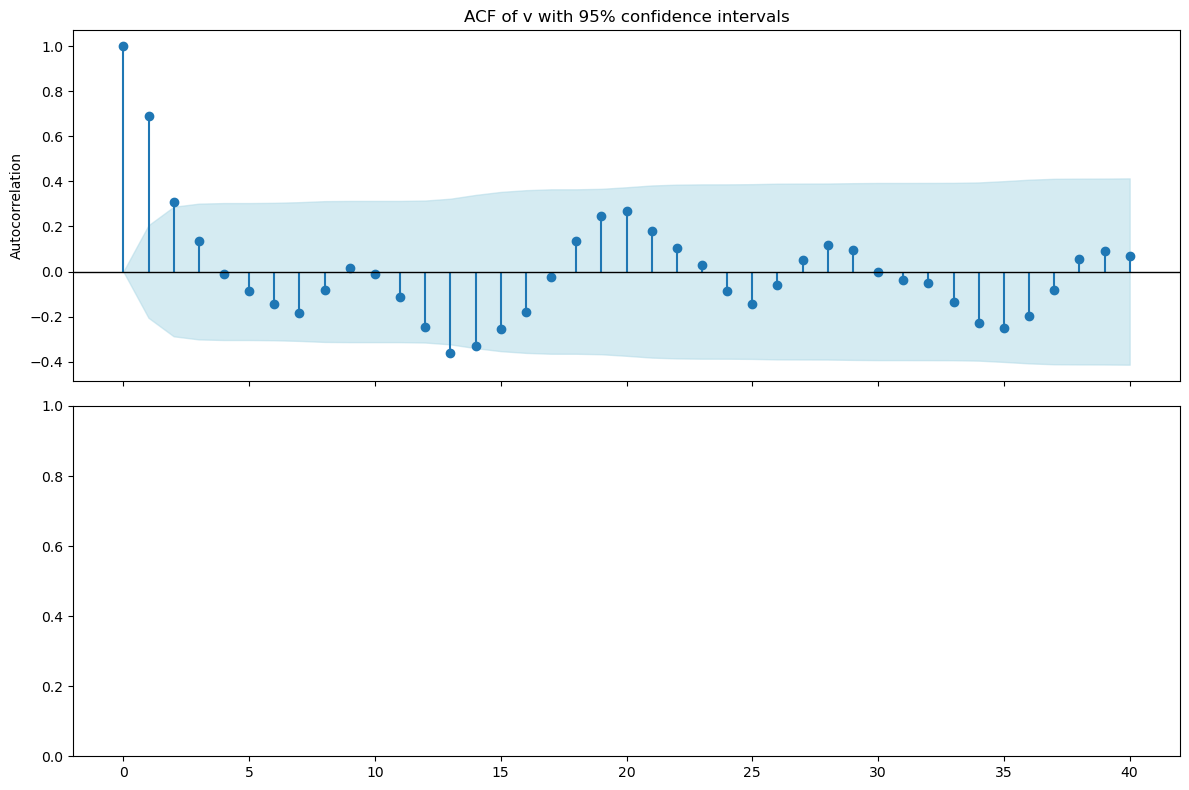

In [50]:
lags = np.arange(len(u_acf))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].stem(lags, u_acf, basefmt=" ", linefmt="C0-", markerfmt="C0o")
axes[0].fill_between(lags, u_confint[:,0] - u_acf, u_confint[:,1]-u_acf,
                     color="lightblue", alpha=0.5)
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("ACF of v with 95% confidence intervals")
axes[0].set_ylabel("Autocorrelation")

# axes[1].plot(lags, p_values_v, marker="o", linestyle="-", color="C1")
# axes[1].axhline(0.05, color="red", linestyle="--", label="p = 0.05")
# axes[1].set_title("p-values for autocorrelations of u")
# axes[1].set_xlabel("Lag")
# axes[1].set_ylabel("p-value")
# axes[1].legend()

plt.tight_layout()
plt.show()

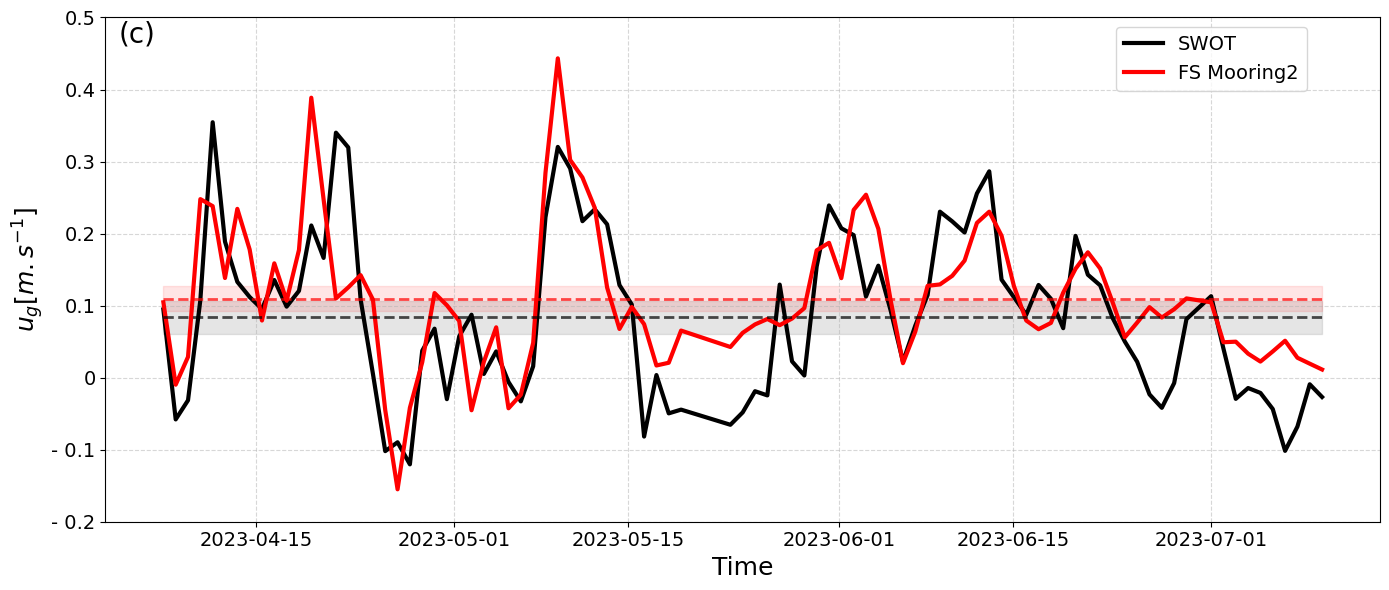

In [52]:
plt.figure(figsize=(14, 6))

plt.plot(df_swot_u.index[mask_nan], u_swot, 'k', linewidth=3, label='SWOT')
plt.plot(df_swot_u.index[mask_nan], u_mooring,'r', linewidth=3, label='FS Mooring2')
plt.fill_between(df_swot_u.index[mask_nan], mean_u - (std_u/np.sqrt(91/3.83)), mean_u + (std_u/np.sqrt(91/3.83)), color='gray', alpha=0.2)
plt.fill_between(df_swot_u.index[mask_nan], mean_u_m - (std_u_m/np.sqrt(91/3)), mean_u_m + (std_u_m/np.sqrt(91/3)), color='r', alpha=0.1)
plt.axhline(mean_u, xmin= 0.045, xmax= 0.955, color='k', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(mean_u_m, xmin= 0.045, xmax= 0.955, color='r', linestyle='--', linewidth=2,alpha=0.7)
plt.xlabel('Time', fontsize=18)
plt.ylabel(r'$u_g[m.s^{-1}]$', fontsize=18)
plt.yticks([-0.2, -0.1, 0, 0.1,0.2,0.3,0.4,0.5], ['- 0.2','- 0.1','0', '0.1', '0.2', '0.3', '0.4','0.5'], fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(bbox_to_anchor=(0.95, 1),fontsize=14)

# plt.text(
#     0.7, 0.1, f"r = {corr_u:.2f}", 
#     color='tomato', weight='bold', transform=plt.gca().transAxes, fontsize=14
# )
# plt.text(
#     0.7, 0.15, f"RMSD = {rmse_u:.2f}", 
#     color='darkred', weight='bold', transform=plt.gca().transAxes, fontsize=14
# )

plt.text(0.01, 0.95, "(c)", fontsize=20, transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=14, colors='k')
plt.tight_layout()
# plt.savefig('Figures/SWOTvsM2.png', dpi=300)
plt.show();

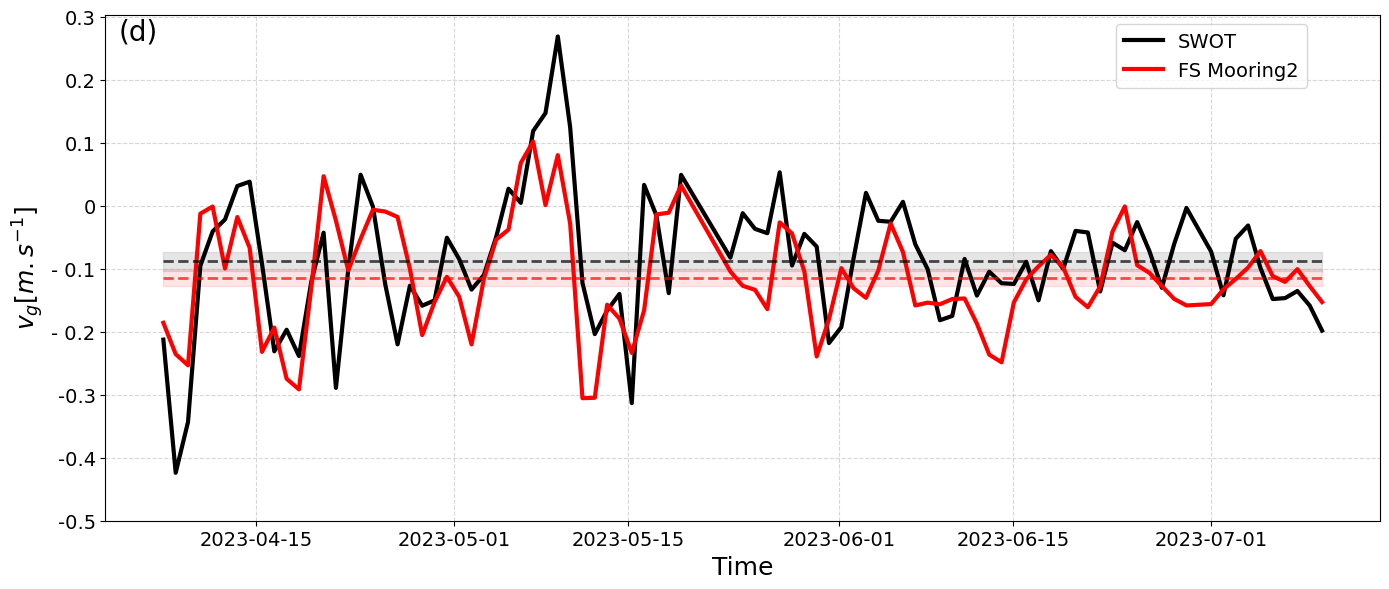

In [54]:
plt.figure(figsize=(14, 6))

# plt.text(
#     0.7, 0.1, f"r = {corr_v:.2f}", 
#     color='tomato', weight='bold', transform=plt.gca().transAxes, fontsize=14
# )
# plt.text(
#     0.7, 0.15, f"RMSD = {rmse_v:.2f}", 
#     color='darkred', weight='bold', transform=plt.gca().transAxes, fontsize=14
# )

plt.plot(df_swot_u.index[mask_nan], v_swot,'k', linewidth=3, label='SWOT')
plt.plot(df_swot_u.index[mask_nan], v_mooring,'r', linewidth=3, label='FS Mooring2')
plt.fill_between(df_swot_u.index[mask_nan], mean_v - (std_v/np.sqrt(91/2.06)), mean_v + (std_v/np.sqrt(91/2.06)), color='gray', alpha=0.2)
plt.fill_between(df_swot_u.index[mask_nan], mean_v_m - (std_v_m/np.sqrt(91/2.17)), mean_v_m + (std_v_m/np.sqrt(91/2.17)), color='r', alpha=0.1)
plt.axhline(mean_v, xmin= 0.045, xmax= 0.955, color='k', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(mean_v_m, xmin= 0.045, xmax= 0.955, color='r', linestyle='--', linewidth=2,alpha=0.7)
plt.xlabel('Time', fontsize=18)
plt.ylabel(r'$v_g[m.s^{-1}]$', fontsize=18)
plt.yticks([-0.5,-0.4,-0.3,-0.2, -0.1, 0, 0.1,0.2,0.3], ['-0.5','-0.4','-0.3','- 0.2','- 0.1','0', '0.1', '0.2', '0.3'], fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(bbox_to_anchor=(0.95, 1),fontsize=14)
plt.text(0.01, 0.95, "(d)", fontsize=20, transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=14, colors='k')
plt.tick_params(axis='y', labelsize=14, colors='k')
plt.tight_layout()

# plt.savefig('Figures/SWOTvsM2_v.png', dpi=300)
plt.show();

In [56]:
std_u_m/np.sqrt(1.69)

0.07297491845695292

In [58]:
np.max(np.sqrt(u_swot**2 + v_swot**2))

0.44640364407478594

In [60]:
np.nanmean(u_mooring)

0.10985159628918767

### Calculate and plot the autocorrelation function

In [63]:
u_auto_r = sm.tsa.acf(u_swot)
v_auto_r = sm.tsa.acf(v_swot)
lags = np.arange(len(u_auto_r))

In [65]:
lags[0:4]

array([0, 1, 2, 3])

In [67]:
#calculate the total area under the curve from the first pt to the 6th pt
integral = np.trapz(np.abs(v_auto_r)[0:4], x= lags[0:4])
integral

1.229462318389969

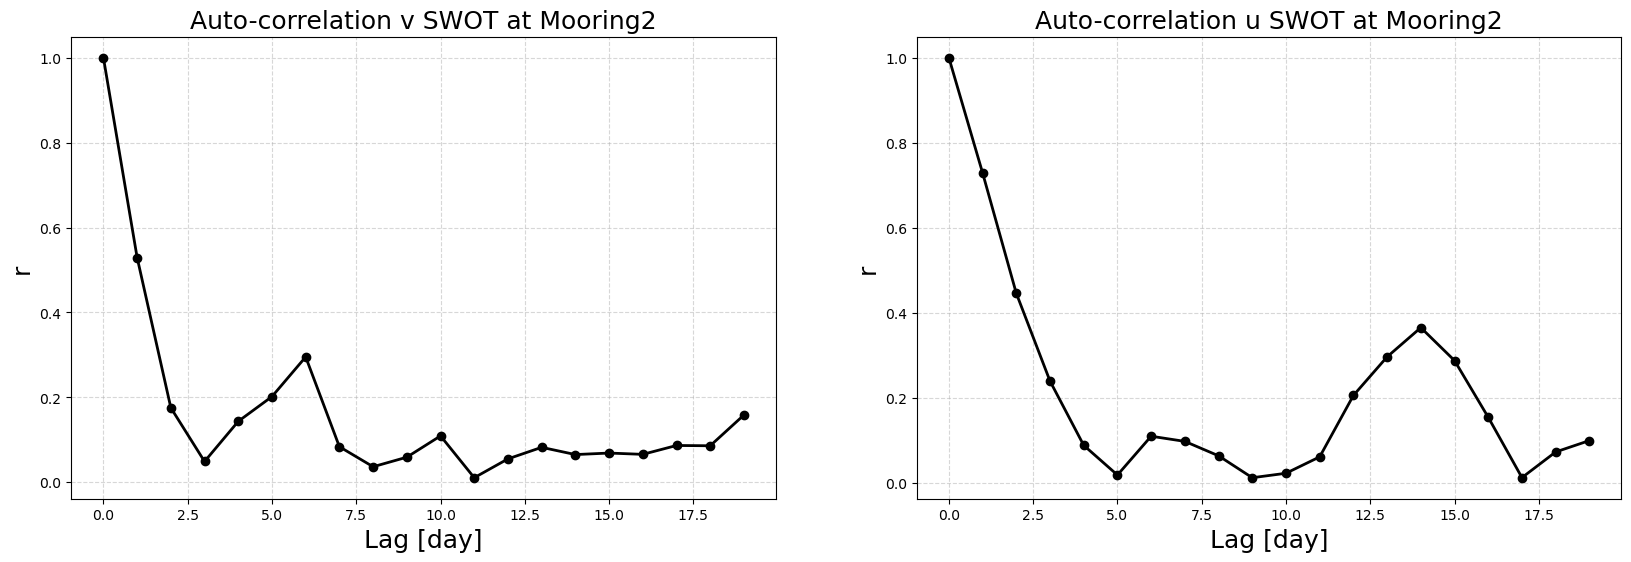

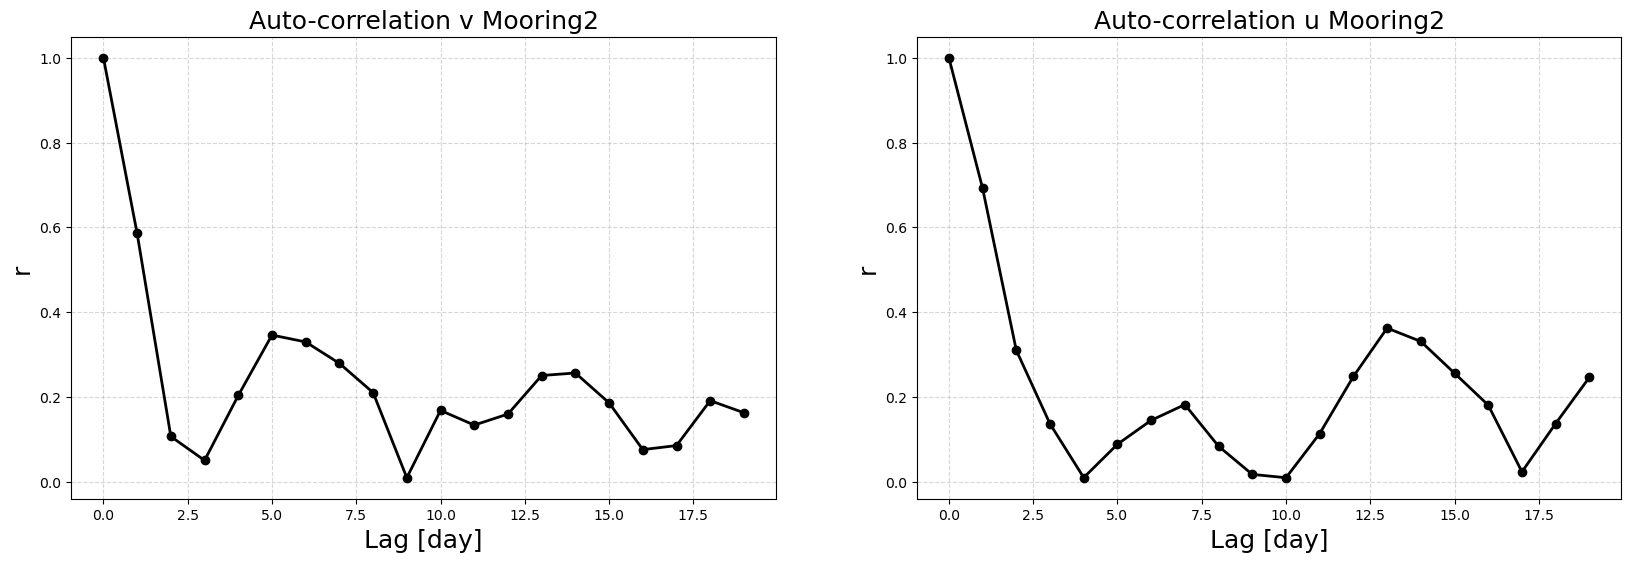

In [69]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))

axs[1].plot(lags, np.abs(u_auto_r), marker='o', color='k', linewidth=2, label='u')
axs[1].set_xlabel('Lag [day]', fontsize=18)
axs[1].set_ylabel('r', fontsize=18)
axs[1].set_title('Auto-correlation u SWOT at Mooring2', fontsize=18)
axs[1].grid(alpha=0.5, linestyle='--')
# axs[1].legend()


axs[0].plot(lags, np.abs(v_auto_r), marker = 'o', color='k', linewidth=2, label='v')
axs[0].set_xlabel('Lag [day]', fontsize=18)
axs[0].set_ylabel('r', fontsize=18)
axs[0].set_title('Auto-correlation v SWOT at Mooring2', fontsize=18)
axs[0].grid(alpha=0.5, linestyle='--')
# axs[0].legend()


u_auto_rm = sm.tsa.acf(u_mooring)
v_auto_rm = sm.tsa.acf(v_mooring)
fig, axs = plt.subplots(1,2, figsize=(20, 6))

axs[1].plot(lags, np.abs(u_auto_rm), marker='o', color='k', linewidth=2, label='u')
axs[1].set_xlabel('Lag [day]', fontsize=18)
axs[1].set_ylabel('r', fontsize=18)
axs[1].set_title('Auto-correlation u Mooring2', fontsize=18)
axs[1].grid(alpha=0.5, linestyle='--')
# axs[1].legend()


axs[0].plot(lags, np.abs(v_auto_rm), marker = 'o', color='k', linewidth=2, label='v')
axs[0].set_xlabel('Lag [day]', fontsize=18)
axs[0].set_ylabel('r', fontsize=18)
axs[0].set_title('Auto-correlation v Mooring2', fontsize=18)
axs[0].grid(alpha=0.5, linestyle='--')
# axs[0].legend()


# plt.savefig('SWOTvsM2.png', dpi=300)
plt.show();